# Data loading and exploration

In [116]:
import optuna
import pandas as pd
import torch
import os
import re
import scipy.io as sio
from glob import glob
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt

import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler

# Detect base directory robustly
try:
    base_dir = os.path.dirname(os.path.dirname(os.path.abspath(__file__)))
except NameError:
    base_dir = os.path.dirname(os.path.abspath(os.getcwd()))


def moving_mean_same(x, window_size=5):
    kernel = np.ones(window_size) / window_size
    return np.convolve(x, kernel, mode='same')

def load_one(file_path, V_rms):
    if not os.path.exists(file_path):
        raise FileNotFoundError(file_path)

    # --- extract metadata from filename ---
    fname = os.path.basename(file_path)
    # Example: sweep_50_500K_9000_1v_t10920_25.8.mat
    m = re.match(r"sweep_(\d+)_([\d\.]+)K_\d+_([\d\.]+)v_t(\d+)_([\d\.]+)\.mat", fname)
    if not m:
        raise ValueError(f"Unexpected filename format: {fname}")
    start_freq = float(m.group(1))
    stop_freq = float(m.group(2)) * 1e3  # convert K→Hz
    stim_voltage = float(m.group(3))
    weight = float(m.group(4)) / 100      # 10920 → 109.20 g
    temperature = float(m.group(5))


    # --- load .mat ---
    S = sio.loadmat(file_path, squeeze_me=True, struct_as_record=False)
    fn = [k for k in S.keys() if not k.startswith("__")]
    dev = getattr(S[fn[0]], "demods", None)
    if dev is None or not hasattr(dev, "sample"):
        raise KeyError(f"No dev.demods.sample in {file_path}")

    s = dev.sample
    if isinstance(s, (list, np.ndarray)) and len(s) > 0:
        s = s[0]

    f = np.array(s.frequency, dtype=float)
    X = np.array(s.x, dtype=float)
    Y = np.array(s.y, dtype=float)

    # Complex current and impedance
    I = X + 1j * Y
    I_mag = np.abs(I)
    epsI = max(np.max(I_mag) * 1e-12, 1e-18)
    I[I_mag < epsI] = epsI

    Z = V_rms / I

    Z = moving_mean_same(V_rms / I, window_size=200)

    R = np.real(Z)
    Xc = np.imag(Z)
    Zmag = np.abs(Z)
    Zphase = np.degrees(np.angle(Z))

    return {
        "file": file_path,
        "f": f,
        "R": R,
        "Xc": Xc,
        "Zmag": Zmag,
        "Zphase": Zphase,
        "weight_g": weight,
        "temperature_C": temperature,
        "V_rms": V_rms,
        "start_freq": start_freq,
        "stop_freq": stop_freq,
        "stim_voltage": stim_voltage,
    }

data_dir = "Datafolder"
full_data_dir = os.path.join(base_dir, data_dir)

files = glob(os.path.join(full_data_dir, "*.mat"))

datasets = [
    load_one(f, V_rms=1.0)
    for f in files
]

# Organize datasets by weight, starting with the highest weight
datasets = sorted(datasets, key=lambda x: x["weight_g"], reverse=True)

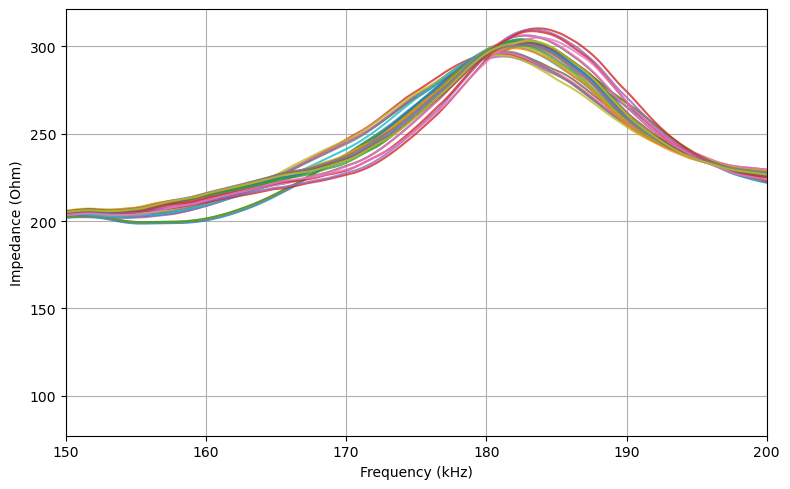

In [117]:
plt.figure(figsize=(8, 5))
for d in datasets:
    label = f"{d['temperature_C']}°C, {d['weight_g']:.2f}g"
    plt.plot(d["f"] / 1000, d["R"], label=f"R - {label}", alpha=0.8)
    #plt.plot(d["f"] / 1000, d["Xc"], linestyle="--", label=f"Xc - {label}", alpha=0.8)

plt.xlim(50, 500)
plt.xlim(150, 200)
plt.xlabel("Frequency (kHz)")
plt.ylabel("Impedance (Ohm)")
#plt.legend(fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()

# ML Pipeline

## 0. Config

In [118]:
# Frequency range parameters (in kHz) for feature extraction 
freq_start_khz = 165
freq_stop_khz = 200

study_focus = "Skew" # Study configuration 


study_name = f"impedance_optimization_{study_focus}_{freq_start_khz}_{freq_stop_khz}kHz" 
storage_url = "sqlite:///optuna_study.db"

fig_folder = f"figures/{study_focus}"
fig_folder = os.path.join(base_dir, fig_folder)

if not os.path.exists(fig_folder):
    os.makedirs(fig_folder)

TUNA_TRAILS = 100
NUM_OF_EPOCHS = 300
N_TRAINING_RUNS = 5  # Number of times to train the model

# Load existing study
study = optuna.create_study(
    study_name=study_name,
    storage=storage_url,
    direction="minimize",
    load_if_exists=True
)

[I 2025-10-24 14:09:36,234] A new study created in RDB with name: impedance_optimization_Skew_165_200kHz


## 1. Data prep

In [119]:
def extract_impedance_features(freqs, R, Xc, R_ref, Xc_ref):
    """Extract damage-relevant features from the real part of impedance."""
    # --- Normalize ---
    #R_norm = R / R_ref
    #Xc_norm = Xc / Xc_ref

        # --- Min–max scale to [0, 1] ---
    def minmax_scale(arr, ref):
        min_ref, max_ref = np.min(ref), np.max(ref)
        if max_ref == min_ref:
            return np.zeros_like(arr)
        return (arr - min_ref) / (max_ref - min_ref)

    R_norm = minmax_scale(R, R_ref)
    Xc_norm = minmax_scale(Xc, Xc_ref)

    # --- Resonance detection ---
    peaks, _ = find_peaks(R)
    if len(peaks) > 0:
        peak_idx = peaks[np.argmax(R[peaks])]
        fr = freqs[peak_idx]
        peak_amp = R[peak_idx]
    else:
        fr = np.nan
        peak_amp = np.nan

    # Quality factor (Q)
    if len(peaks) > 0:
        half_max = peak_amp / 2
        above_half = np.where(R > half_max)[0]
        if len(above_half) > 1:
            fwhm = freqs[above_half[-1]] - freqs[above_half[0]]
            Q = fr / fwhm if fwhm != 0 else np.nan
        else:
            Q = np.nan
    else:
        Q = np.nan

    # --- Phase slope near resonance ---
    Z = R + 1j * Xc
    phase = np.unwrap(np.angle(Z))
    if len(peaks) > 0 and 2 < peak_idx < len(phase) - 2:
        df = freqs[1] - freqs[0]
        slope = np.gradient(phase, df)[peak_idx]
    else:
        slope = np.nan

    # --- Statistical summaries ---
    mean_R = np.mean(R)
    var_R = np.var(R)
    skew_R = skew(R)

    # --- RMS deviation from reference ---
    rms_dev = np.sqrt(np.mean((R - R_ref) ** 2))

    # --- Correlation coefficient ---
    if np.std(R_ref) > 0 and np.std(R) > 0:
        corr_coef = np.corrcoef(R, R_ref)[0, 1]
    else:
        corr_coef = np.nan

    # --- Area between curves ---
    area_diff = np.trapz(np.abs(R - R_ref), freqs)

    # --- Combine ---
    # features = np.concatenate([
    #     R_norm,
    #     Xc_norm,
    #     [
    #         fr,
    #         Q,
    #         peak_amp,
    #         slope,
    #         mean_R,
    #         var_R,
    #         skew_R,
    #         rms_dev,
    #         corr_coef,
    #         area_diff,
    #     ],
    # ])

    features = np.concatenate([
        [
            skew_R,
        ],
    ])
    return features

In [ ]:
import numpy as np
from scipy.signal import find_peaks
from scipy.stats import skew
from sklearn.preprocessing import StandardScaler


# ---------------- Main dataset loop ----------------
freqs = datasets[0]["f"]
X_data, y_data = [], []

# Reference data
freq_khz_ref = freqs / 1000
freq_mask_ref = (freq_khz_ref >= freq_start_khz) & (freq_khz_ref <= freq_stop_khz)
R_ref = datasets[0]["R"][freq_mask_ref]
Xc_ref = datasets[0]["Xc"][freq_mask_ref]
freqs_ref = freqs[freq_mask_ref]

for d in datasets:
    freq_khz = d["f"] / 1000
    freq_mask = (freq_khz >= freq_start_khz) & (freq_khz <= freq_stop_khz)

    freqs_sel = d["f"][freq_mask]
    R = d["R"][freq_mask]
    Xc = d["Xc"][freq_mask]

    features = extract_impedance_features(freqs_sel, R, Xc, R_ref, Xc_ref)
    X_data.append(features)
    y_data.append(d["weight_g"] - 115.0)  # delta weight

X_data = np.array(X_data, dtype=np.float32)
y_data = np.array(y_data, dtype=np.float32).reshape(-1, 1)

scaler = StandardScaler()
X_data = scaler.fit_transform(X_data)


/tmp/ipykernel_851/753938169.py:63: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area_diff = np.trapz(np.abs(R - R_ref), freqs)


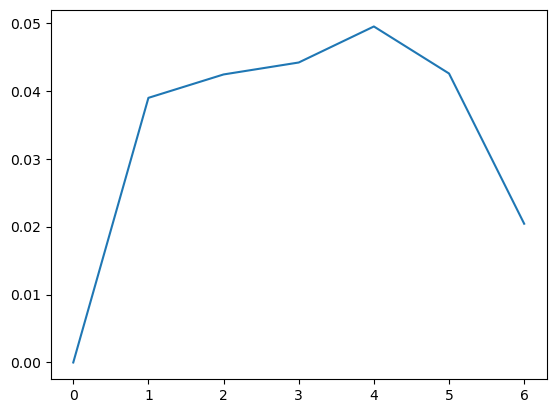

In [167]:
plt.plot(X_eval_data-X_eval_data[0])

In [122]:
def unpack_features(features, R_ref, Xc_ref):
    n_R = len(R_ref)
    n_Xc = len(Xc_ref)
    return {
        "R_norm": features[:n_R],
        "Xc_norm": features[n_R:n_R + n_Xc],
        "fr": features[n_R + n_Xc + 0],
        "Q": features[n_R + n_Xc + 1],
        "peak_amp": features[n_R + n_Xc + 2],
        "slope": features[n_R + n_Xc + 3],
        "mean_R": features[n_R + n_Xc + 4],
        "var_R": features[n_R + n_Xc + 5],
        "skew_R": features[n_R + n_Xc + 6],
        "rms_dev": features[n_R + n_Xc + 7],
        "corr_coef": features[n_R + n_Xc + 8],
        "area_diff": features[n_R + n_Xc + 9],
    }


In [123]:
import numpy as np
import matplotlib.pyplot as plt

# Extract Q values
n_R = len(R_ref)
n_Xc = len(Xc_ref)
q_index = n_R + n_Xc + 6  # Q is second scalar feature after fr

Q_train = X_data[:, q_index]
Q_eval = X_eval_data[:, q_index]

# Compute delta Q relative to first sample
delta_Q_train = Q_train - Q_train[0]
delta_Q_eval = Q_eval - Q_eval[0]

# Sample indices
idx_train = np.arange(len(delta_Q_train))
idx_eval = np.arange(len(delta_Q_eval))

# Linear fit
fit_train = np.polyfit(idx_train, delta_Q_train, 1)
fit_eval = np.polyfit(idx_eval, delta_Q_eval, 1)

# Slopes
slope_train = fit_train[0]
slope_eval = fit_eval[0]

# Evaluate linear fit
delta_Q_train_fit = np.polyval(fit_train, idx_train)
delta_Q_eval_fit = np.polyval(fit_eval, idx_eval)

# Plot
plt.figure()
plt.plot(idx_train, delta_Q_train, "o-", label=f"Mehdi dataset")
plt.plot(idx_eval, delta_Q_eval, "s-", label=f"Force dataset")
plt.plot(idx_train, delta_Q_train_fit, "r--", label=f"Mehdi trend (slope={slope_train:.4f})")
plt.plot(idx_eval, delta_Q_eval_fit, "g--", label=f"Force trend (slope={slope_eval:.4f})")
plt.xlabel("Sample index")
plt.ylabel("Skew (relative to first sample)")
plt.title("Change in skew factor across datasets with linear trend")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


IndexError: index 1406 is out of bounds for axis 1 with size 1

### Explore correlations

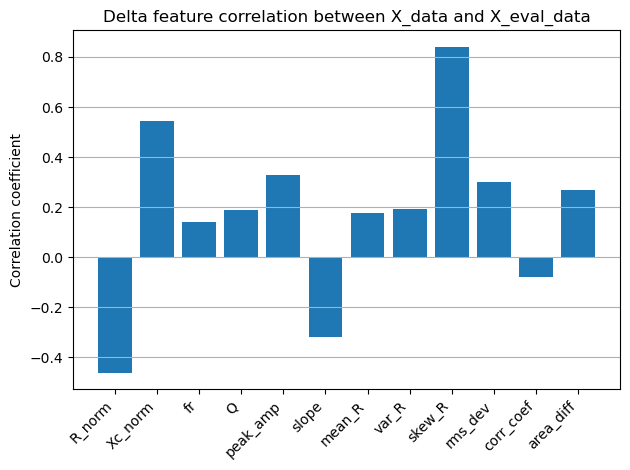

ΔR_norm: -0.463
ΔXc_norm: 0.543
Δfr: 0.139
ΔQ: 0.190
Δpeak_amp: 0.330
Δslope: -0.321
Δmean_R: 0.175
Δvar_R: 0.193
Δskew_R: 0.841
Δrms_dev: 0.300
Δcorr_coef: -0.079
Δarea_diff: 0.267


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Wrapper to reconstruct named features from flattened vector
def unpack_features_vector(x, R_ref, Xc_ref):
    n = len(R_ref)
    R_norm = x[:n]          # Normalized real part of impedance (scaled 0-1)
    Xc_norm = x[n:2*n]      # Normalized imaginary part of impedance (scaled 0-1)
    scalars = x[2*n:]       # Remaining scalar features
    return {
        "R_norm": R_norm,              # Real impedance magnitude
        "Xc_norm": Xc_norm,            # Imaginary impedance magnitude
        "fr": scalars[0],              # Resonance frequency
        "Q": scalars[1],               # Quality factor
        "peak_amp": scalars[2],        # Peak amplitude at resonance
        "slope": scalars[3],           # Phase slope near resonance
        "mean_R": scalars[4],          # Mean of real impedance
        "var_R": scalars[5],           # Variance of real impedance
        "skew_R": scalars[6],          # Skewness of real impedance
        "rms_dev": scalars[7],         # RMS deviation from reference
        "corr_coef": scalars[8],       # Correlation with reference spectrum
        "area_diff": scalars[9],       # Area difference between curve and reference
    }


# Aggregate features for all samples
def unpack_all_features(X, R_ref, Xc_ref):
    unpacked = []
    for i in range(X.shape[0]):
        f = unpack_features_vector(X[i], R_ref, Xc_ref)
        # Replace arrays with their mean (for correlation)
        f_summary = {k: np.mean(v) if isinstance(v, np.ndarray) else v for k, v in f.items()}
        unpacked.append(f_summary)
    return pd.DataFrame(unpacked)

# --- Use it ---
df_train = unpack_all_features(X_data, R_ref, Xc_ref)
df_eval = unpack_all_features(X_eval_data, R_ref, Xc_ref)

# Compute delta features relative to first sample in each dataset
df_train_delta = df_train.copy()
df_eval_delta = df_eval.copy()

# For training data: delta from first sample
first_train = df_train.iloc[0]
for col in df_train.columns:
    df_train_delta[col] = df_train[col] - first_train[col]

# For evaluation data: delta from first sample
first_eval = df_eval.iloc[0]
for col in df_eval.columns:
    df_eval_delta[col] = df_eval[col] - first_eval[col]

# Match lengths by subsampling
n_eval = len(df_eval_delta)
idx = np.linspace(0, len(df_train_delta) - 1, n_eval).astype(int)
df_train_delta_sub = df_train_delta.iloc[idx].reset_index(drop=True)
df_eval_delta = df_eval_delta.reset_index(drop=True)

# Compute feature correlations on delta features
scalar_features = [c for c in df_train_delta_sub.columns if not isinstance(df_train_delta_sub[c].iloc[0], np.ndarray)]
corrs = {f: np.corrcoef(df_train_delta_sub[f], df_eval_delta[f])[0, 1] for f in scalar_features}

# Plot
plt.bar(list(corrs.keys()), list(corrs.values()))
plt.ylabel("Correlation coefficient")
plt.xticks(rotation=45, ha="right")
plt.title("Delta feature correlation between X_data and X_eval_data")
plt.grid(True, axis="y")
plt.tight_layout()
plt.show()

# Print results
for f, c in corrs.items():
    print(f"Δ{f}: {c:.3f}")

## 2. Pytorch dataset

In [124]:
class ImpedanceDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

dataset = ImpedanceDataset(X_data, y_data)


## 3. Train/Validate split

In [125]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.3, random_state=42)
train_ds = ImpedanceDataset(X_train, y_train)
val_ds = ImpedanceDataset(X_val, y_val)
train_loader = DataLoader(train_ds, batch_size=8, shuffle=False)
val_loader = DataLoader(val_ds, batch_size=8, shuffle=False)

## 4. Define model

In [126]:
class ImpedanceNet(torch.nn.Module):
    def __init__(self, input_dim, hidden_channels, kernel_size, stride, dropout):
        super().__init__()
        self.input_dim = input_dim
        
        # Calculate dimensions after conv layers
        def conv_output_size(input_size, kernel_size, stride, padding):
            return (input_size + 2 * padding - kernel_size) // stride + 1
        
        # First conv layer
        padding1 = kernel_size // 2
        size_after_conv1 = conv_output_size(input_dim, kernel_size, stride, padding1)
        
        # Second conv layer  
        size_after_conv2 = conv_output_size(size_after_conv1, kernel_size, stride, padding1)
        
        # Third conv layer
        size_after_conv3 = conv_output_size(size_after_conv2, kernel_size, stride, padding1)
        
        self.conv_layers = torch.nn.Sequential(
            torch.nn.Conv1d(1, hidden_channels, kernel_size, stride=stride, padding=padding1),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout),
            torch.nn.Conv1d(hidden_channels, hidden_channels*2, kernel_size, stride=stride, padding=padding1),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout),
            torch.nn.Conv1d(hidden_channels*2, hidden_channels*4, kernel_size, stride=stride, padding=padding1),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout)
        )
        
        # Calculate final feature size
        final_features = hidden_channels * 4 * size_after_conv3
        self.fc = torch.nn.Linear(final_features, 1)
        
    def forward(self, x):
        # x shape: (batch, features) -> (batch, 1, features)
        x = x.unsqueeze(1)
        x = self.conv_layers(x)
        x = x.flatten(1)
        return self.fc(x)

## 5. Optuna hyperparam search

In [127]:
# Check CUDA availability and GPU information
print("CUDA Setup Information:")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    print(f"Current GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
else:
    print("CUDA not available - will use CPU for training")
print()

CUDA Setup Information:
CUDA Available: True
CUDA Version: 11.8
Number of GPUs: 1
Current GPU: NVIDIA GeForce RTX 4090
GPU Memory: 25.8 GB



In [128]:
def objective(trial):
    # Check if CUDA is available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Hyperparameters to optimize
    hidden_channels = trial.suggest_int("hidden_channels", 4, 128)
    kernel_size = trial.suggest_int("kernel_size", 3, 40, step=2)
    stride = trial.suggest_int("stride", 1, 40) 
    dropout = trial.suggest_float("dropout", 0.0, 1)
    lr = trial.suggest_float("lr", 1e-6, 1e-2, log=True)
    epochs = NUM_OF_EPOCHS

    try:
        model = ImpedanceNet(X_train.shape[1], hidden_channels, kernel_size, stride, dropout)
        model = model.to(device)  # Move model to GPU if available
        
        opt = torch.optim.Adam(model.parameters(), lr=lr)
        loss_fn = torch.nn.MSELoss()

        for epoch in range(epochs):
            model.train()
            for xb, yb in train_loader:
                xb, yb = xb.to(device), yb.to(device)  # Move data to GPU
                pred = model(xb)
                loss = loss_fn(pred, yb)
                opt.zero_grad()
                loss.backward()
                opt.step()

        # Validation loss
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)  # Move data to GPU
                pred = model(xb)
                val_loss += loss_fn(pred, yb).item()
        
        return val_loss / len(val_loader)
        
    except RuntimeError as e:
        if "out of memory" in str(e):
            # If GPU runs out of memory, return a high loss to penalize this configuration
            print(f"GPU out of memory for trial {trial.number}: {e}")
            return float('inf')
        else:
            raise e

study = optuna.create_study(
    study_name=study_name,
    storage=storage_url,
    direction="minimize",
    load_if_exists=True  # Load existing study if it exists
)

print(f"Study created/loaded: {study_name}")
print(f"Database URL: {storage_url}")
print(f"Number of completed trials: {len(study.trials)}")

study.optimize(objective, n_trials=TUNA_TRAILS)  # Increased trials for better exploration

print(f"\nBest parameters: {study.best_params}")
print(f"Best validation loss: {study.best_value:.4f}")
print(f"\nTo view results in dashboard, run:")
print(f"optuna-dashboard {storage_url}")

[I 2025-10-24 14:09:51,439] Using an existing study with name 'impedance_optimization_Skew_165_200kHz' instead of creating a new one.


Study created/loaded: impedance_optimization_Skew_165_200kHz
Database URL: sqlite:///optuna_study.db
Number of completed trials: 0
Using device: cuda


/home/au585732/miniconda3/envs/corro_ml_env/lib/python3.10/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [3, 40] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 39].
  warnings.warn(
[I 2025-10-24 14:09:53,931] Trial 0 finished with value: 0.8355132937431335 and parameters: {'hidden_channels': 117, 'kernel_size': 3, 'stride': 32, 'dropout': 0.13093247034620692, 'lr': 0.0006840128907568604}. Best is trial 0 with value: 0.8355132937431335.
/home/au585732/miniconda3/envs/corro_ml_env/lib/python3.10/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [3, 40] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 39].
  warnings.warn(


Using device: cuda


[I 2025-10-24 14:09:55,130] Trial 1 finished with value: 1.65854874253273 and parameters: {'hidden_channels': 50, 'kernel_size': 17, 'stride': 7, 'dropout': 0.49554701970241466, 'lr': 0.00014665982353770344}. Best is trial 0 with value: 0.8355132937431335.


Using device: cuda


[I 2025-10-24 14:09:56,259] Trial 2 finished with value: 17.72113561630249 and parameters: {'hidden_channels': 7, 'kernel_size': 37, 'stride': 26, 'dropout': 0.8054924869608135, 'lr': 6.608544319141274e-05}. Best is trial 0 with value: 0.8355132937431335.


Using device: cuda


[I 2025-10-24 14:09:57,521] Trial 3 finished with value: 2.253819465637207 and parameters: {'hidden_channels': 35, 'kernel_size': 3, 'stride': 23, 'dropout': 0.4561923549695621, 'lr': 0.0014020318668974494}. Best is trial 0 with value: 0.8355132937431335.


Using device: cuda


[I 2025-10-24 14:09:58,702] Trial 4 finished with value: 0.9950765669345856 and parameters: {'hidden_channels': 68, 'kernel_size': 13, 'stride': 5, 'dropout': 0.07266570531675598, 'lr': 9.253535530083124e-05}. Best is trial 0 with value: 0.8355132937431335.


Using device: cuda


[I 2025-10-24 14:09:59,854] Trial 5 finished with value: 2.3669490814208984 and parameters: {'hidden_channels': 92, 'kernel_size': 29, 'stride': 6, 'dropout': 0.8651795204598013, 'lr': 0.0032558221547056387}. Best is trial 0 with value: 0.8355132937431335.


Using device: cuda


[I 2025-10-24 14:10:01,025] Trial 6 finished with value: 5.468778371810913 and parameters: {'hidden_channels': 88, 'kernel_size': 39, 'stride': 34, 'dropout': 0.9628586904349715, 'lr': 0.0003706544894616018}. Best is trial 0 with value: 0.8355132937431335.


Using device: cuda


[I 2025-10-24 14:10:02,186] Trial 7 finished with value: 19.687122344970703 and parameters: {'hidden_channels': 52, 'kernel_size': 39, 'stride': 23, 'dropout': 0.36201328146499556, 'lr': 6.295229280553389e-06}. Best is trial 0 with value: 0.8355132937431335.


Using device: cuda


[I 2025-10-24 14:10:03,397] Trial 8 finished with value: 4.490204572677612 and parameters: {'hidden_channels': 98, 'kernel_size': 11, 'stride': 7, 'dropout': 0.23165415416972635, 'lr': 1.2563090653230052e-05}. Best is trial 0 with value: 0.8355132937431335.


Using device: cuda


[I 2025-10-24 14:10:04,550] Trial 9 finished with value: 19.029942512512207 and parameters: {'hidden_channels': 16, 'kernel_size': 31, 'stride': 17, 'dropout': 0.9931420749517748, 'lr': 4.59250198144116e-05}. Best is trial 0 with value: 0.8355132937431335.


Using device: cuda


[I 2025-10-24 14:10:05,789] Trial 10 finished with value: 19.9229793548584 and parameters: {'hidden_channels': 128, 'kernel_size': 5, 'stride': 40, 'dropout': 0.05848398436819807, 'lr': 1.3425832808831403e-06}. Best is trial 0 with value: 0.8355132937431335.


Using device: cuda


[I 2025-10-24 14:10:07,066] Trial 11 finished with value: 0.8288353383541107 and parameters: {'hidden_channels': 121, 'kernel_size': 13, 'stride': 14, 'dropout': 0.004840369305871617, 'lr': 0.0006244315111650011}. Best is trial 11 with value: 0.8288353383541107.


Using device: cuda


[I 2025-10-24 14:10:08,294] Trial 12 finished with value: 0.8085687756538391 and parameters: {'hidden_channels': 127, 'kernel_size': 9, 'stride': 14, 'dropout': 0.0009844528358820838, 'lr': 0.0004536042842952386}. Best is trial 12 with value: 0.8085687756538391.


Using device: cuda


[I 2025-10-24 14:10:09,473] Trial 13 finished with value: 0.785325676202774 and parameters: {'hidden_channels': 112, 'kernel_size': 21, 'stride': 15, 'dropout': 0.25629347658982465, 'lr': 0.007855145020622026}. Best is trial 13 with value: 0.785325676202774.


Using device: cuda


[I 2025-10-24 14:10:10,660] Trial 14 finished with value: 1.0485526025295258 and parameters: {'hidden_channels': 104, 'kernel_size': 23, 'stride': 13, 'dropout': 0.289913704070134, 'lr': 0.00616695300917658}. Best is trial 13 with value: 0.785325676202774.


Using device: cuda


[I 2025-10-24 14:10:11,901] Trial 15 finished with value: 1.0419666171073914 and parameters: {'hidden_channels': 74, 'kernel_size': 21, 'stride': 12, 'dropout': 0.19717558061074084, 'lr': 0.006408921632533964}. Best is trial 13 with value: 0.785325676202774.


Using device: cuda


[I 2025-10-24 14:10:13,085] Trial 16 finished with value: 1.079114556312561 and parameters: {'hidden_channels': 110, 'kernel_size': 9, 'stride': 1, 'dropout': 0.6304042313134328, 'lr': 0.0020434460594513262}. Best is trial 13 with value: 0.785325676202774.


Using device: cuda


[I 2025-10-24 14:10:14,317] Trial 17 finished with value: 0.9409785568714142 and parameters: {'hidden_channels': 82, 'kernel_size': 25, 'stride': 18, 'dropout': 0.3600416353729467, 'lr': 0.009090514880880713}. Best is trial 13 with value: 0.785325676202774.


Using device: cuda


[I 2025-10-24 14:10:15,494] Trial 18 finished with value: 1.0264585614204407 and parameters: {'hidden_channels': 110, 'kernel_size': 17, 'stride': 11, 'dropout': 0.1489023312482311, 'lr': 0.0002641585496968369}. Best is trial 13 with value: 0.785325676202774.


Using device: cuda


[I 2025-10-24 14:10:16,733] Trial 19 finished with value: 1.6729171872138977 and parameters: {'hidden_channels': 124, 'kernel_size': 19, 'stride': 28, 'dropout': 0.6243279073455155, 'lr': 0.0017817637237192675}. Best is trial 13 with value: 0.785325676202774.


Using device: cuda


[I 2025-10-24 14:10:17,941] Trial 20 finished with value: 1.2817423343658447 and parameters: {'hidden_channels': 100, 'kernel_size': 7, 'stride': 19, 'dropout': 0.2928164167203505, 'lr': 1.9769945315395288e-05}. Best is trial 13 with value: 0.785325676202774.


Using device: cuda


[I 2025-10-24 14:10:19,150] Trial 21 finished with value: 0.8289399147033691 and parameters: {'hidden_channels': 120, 'kernel_size': 15, 'stride': 15, 'dropout': 0.015136827133435865, 'lr': 0.0008037306755187139}. Best is trial 13 with value: 0.785325676202774.


Using device: cuda


[I 2025-10-24 14:10:20,413] Trial 22 finished with value: 0.8213213086128235 and parameters: {'hidden_channels': 121, 'kernel_size': 11, 'stride': 12, 'dropout': 0.011932582786505101, 'lr': 0.0003950824379837069}. Best is trial 13 with value: 0.785325676202774.


Using device: cuda


[I 2025-10-24 14:10:21,624] Trial 23 finished with value: 1.0366612672805786 and parameters: {'hidden_channels': 110, 'kernel_size': 9, 'stride': 10, 'dropout': 0.13318456269049228, 'lr': 0.00025663931743354247}. Best is trial 13 with value: 0.785325676202774.


Using device: cuda


[I 2025-10-24 14:10:22,837] Trial 24 finished with value: 0.9599994719028473 and parameters: {'hidden_channels': 126, 'kernel_size': 27, 'stride': 1, 'dropout': 0.09921219727037286, 'lr': 0.0001670833571276928}. Best is trial 13 with value: 0.785325676202774.


Using device: cuda


[I 2025-10-24 14:10:24,045] Trial 25 finished with value: 0.6204142272472382 and parameters: {'hidden_channels': 81, 'kernel_size': 33, 'stride': 21, 'dropout': 0.21891786415281395, 'lr': 0.0035086779224104267}. Best is trial 25 with value: 0.6204142272472382.


Using device: cuda


[I 2025-10-24 14:10:25,270] Trial 26 finished with value: 1.0427973866462708 and parameters: {'hidden_channels': 80, 'kernel_size': 35, 'stride': 22, 'dropout': 0.4125096844984316, 'lr': 0.003675454395891522}. Best is trial 25 with value: 0.6204142272472382.


Using device: cuda


[I 2025-10-24 14:10:26,529] Trial 27 finished with value: 1.7570874691009521 and parameters: {'hidden_channels': 61, 'kernel_size': 33, 'stride': 27, 'dropout': 0.588089719532854, 'lr': 0.0034917911408662828}. Best is trial 25 with value: 0.6204142272472382.


Using device: cuda


[I 2025-10-24 14:10:27,819] Trial 28 finished with value: 1.0214459896087646 and parameters: {'hidden_channels': 91, 'kernel_size': 23, 'stride': 20, 'dropout': 0.23915497291765953, 'lr': 0.001361932971391316}. Best is trial 25 with value: 0.6204142272472382.


Using device: cuda


[I 2025-10-24 14:10:29,057] Trial 29 finished with value: 1.0782729089260101 and parameters: {'hidden_channels': 114, 'kernel_size': 29, 'stride': 31, 'dropout': 0.1733609217763586, 'lr': 0.0007674813888880318}. Best is trial 25 with value: 0.6204142272472382.


Using device: cuda


[I 2025-10-24 14:10:30,246] Trial 30 finished with value: 1.6254733502864838 and parameters: {'hidden_channels': 30, 'kernel_size': 33, 'stride': 15, 'dropout': 0.29220727068641783, 'lr': 0.008288143944102174}. Best is trial 25 with value: 0.6204142272472382.


Using device: cuda


[I 2025-10-24 14:10:31,444] Trial 31 finished with value: 0.7729856669902802 and parameters: {'hidden_channels': 116, 'kernel_size': 5, 'stride': 9, 'dropout': 0.07252138435411115, 'lr': 0.0005235080633966873}. Best is trial 25 with value: 0.6204142272472382.


Using device: cuda


[I 2025-10-24 14:10:32,710] Trial 32 finished with value: 1.0240198969841003 and parameters: {'hidden_channels': 103, 'kernel_size': 3, 'stride': 9, 'dropout': 0.10703339683494562, 'lr': 0.002902138586197308}. Best is trial 25 with value: 0.6204142272472382.


Using device: cuda


[I 2025-10-24 14:10:33,974] Trial 33 finished with value: 0.7554914057254791 and parameters: {'hidden_channels': 117, 'kernel_size': 7, 'stride': 17, 'dropout': 0.17539303279028254, 'lr': 0.0010346102715941003}. Best is trial 25 with value: 0.6204142272472382.


Using device: cuda


[I 2025-10-24 14:10:35,192] Trial 34 finished with value: 0.8100369870662689 and parameters: {'hidden_channels': 116, 'kernel_size': 5, 'stride': 17, 'dropout': 0.20125450623970167, 'lr': 0.0011560646424415796}. Best is trial 25 with value: 0.6204142272472382.


Using device: cuda


[I 2025-10-24 14:10:36,435] Trial 35 finished with value: 1.4158053994178772 and parameters: {'hidden_channels': 98, 'kernel_size': 17, 'stride': 24, 'dropout': 0.3376704301290579, 'lr': 0.004637153180760809}. Best is trial 25 with value: 0.6204142272472382.


Using device: cuda


[I 2025-10-24 14:10:37,598] Trial 36 finished with value: 0.9075278639793396 and parameters: {'hidden_channels': 56, 'kernel_size': 5, 'stride': 4, 'dropout': 0.41787687556632425, 'lr': 0.0020596711405880467}. Best is trial 25 with value: 0.6204142272472382.


Using device: cuda


[I 2025-10-24 14:10:38,879] Trial 37 finished with value: 1.0866223871707916 and parameters: {'hidden_channels': 107, 'kernel_size': 3, 'stride': 20, 'dropout': 0.5116985022262915, 'lr': 0.0011801676665783307}. Best is trial 25 with value: 0.6204142272472382.


Using device: cuda


[I 2025-10-24 14:10:40,121] Trial 38 finished with value: 1.2523943781852722 and parameters: {'hidden_channels': 41, 'kernel_size': 37, 'stride': 9, 'dropout': 0.24315784563779202, 'lr': 0.005076184288353277}. Best is trial 25 with value: 0.6204142272472382.


Using device: cuda


[I 2025-10-24 14:10:41,384] Trial 39 finished with value: 1.873460292816162 and parameters: {'hidden_channels': 69, 'kernel_size': 13, 'stride': 16, 'dropout': 0.7353389740676601, 'lr': 0.00012773205052273856}. Best is trial 25 with value: 0.6204142272472382.


Using device: cuda


[I 2025-10-24 14:10:42,612] Trial 40 finished with value: 0.8546269237995148 and parameters: {'hidden_channels': 95, 'kernel_size': 7, 'stride': 22, 'dropout': 0.07390555078089656, 'lr': 0.002721257394762654}. Best is trial 25 with value: 0.6204142272472382.


Using device: cuda


[I 2025-10-24 14:10:43,917] Trial 41 finished with value: 0.8601966202259064 and parameters: {'hidden_channels': 115, 'kernel_size': 9, 'stride': 8, 'dropout': 0.0532376842594411, 'lr': 0.0004982325688032292}. Best is trial 25 with value: 0.6204142272472382.


Using device: cuda


[I 2025-10-24 14:10:45,050] Trial 42 finished with value: 0.9351194798946381 and parameters: {'hidden_channels': 86, 'kernel_size': 7, 'stride': 25, 'dropout': 0.14947951515096589, 'lr': 5.5072041470246986e-05}. Best is trial 25 with value: 0.6204142272472382.


Using device: cuda


[I 2025-10-24 14:10:46,273] Trial 43 finished with value: 0.8566027283668518 and parameters: {'hidden_channels': 127, 'kernel_size': 13, 'stride': 4, 'dropout': 0.053022501716129704, 'lr': 0.00023961206807144705}. Best is trial 25 with value: 0.6204142272472382.


Using device: cuda


[I 2025-10-24 14:10:47,545] Trial 44 finished with value: 0.6514062583446503 and parameters: {'hidden_channels': 117, 'kernel_size': 11, 'stride': 14, 'dropout': 0.11804149759602527, 'lr': 0.0009365248269915929}. Best is trial 25 with value: 0.6204142272472382.


Using device: cuda


[I 2025-10-24 14:10:48,784] Trial 45 finished with value: 0.8034112453460693 and parameters: {'hidden_channels': 115, 'kernel_size': 11, 'stride': 18, 'dropout': 0.2520164473558383, 'lr': 0.001031103451124349}. Best is trial 25 with value: 0.6204142272472382.


Using device: cuda


[I 2025-10-24 14:10:49,914] Trial 46 finished with value: 0.8598984479904175 and parameters: {'hidden_channels': 104, 'kernel_size': 19, 'stride': 6, 'dropout': 0.19674681306338587, 'lr': 0.0018663129616606653}. Best is trial 25 with value: 0.6204142272472382.


Using device: cuda


[I 2025-10-24 14:10:51,141] Trial 47 finished with value: 0.9455501139163971 and parameters: {'hidden_channels': 95, 'kernel_size': 15, 'stride': 13, 'dropout': 0.10917562856858506, 'lr': 0.0006998056031124834}. Best is trial 25 with value: 0.6204142272472382.


Using device: cuda


[I 2025-10-24 14:10:52,289] Trial 48 finished with value: 19.560689449310303 and parameters: {'hidden_channels': 120, 'kernel_size': 5, 'stride': 11, 'dropout': 0.3117548970568722, 'lr': 2.042281559473617e-06}. Best is trial 25 with value: 0.6204142272472382.


Using device: cuda


[I 2025-10-24 14:10:53,614] Trial 49 finished with value: 1.0419915914535522 and parameters: {'hidden_channels': 109, 'kernel_size': 25, 'stride': 21, 'dropout': 0.1723585815055984, 'lr': 7.815870893439145e-05}. Best is trial 25 with value: 0.6204142272472382.


Using device: cuda


[I 2025-10-24 14:10:54,806] Trial 50 finished with value: 1.1047564148902893 and parameters: {'hidden_channels': 73, 'kernel_size': 3, 'stride': 16, 'dropout': 0.4020005682503703, 'lr': 0.009734251811205302}. Best is trial 25 with value: 0.6204142272472382.


Using device: cuda


[I 2025-10-24 14:10:55,957] Trial 51 finished with value: 1.0946848690509796 and parameters: {'hidden_channels': 114, 'kernel_size': 11, 'stride': 18, 'dropout': 0.2344277699273785, 'lr': 0.0008735043024667066}. Best is trial 25 with value: 0.6204142272472382.


Using device: cuda


[I 2025-10-24 14:10:57,198] Trial 52 finished with value: 0.766670823097229 and parameters: {'hidden_channels': 117, 'kernel_size': 11, 'stride': 18, 'dropout': 0.26540449025133733, 'lr': 0.001108646184386002}. Best is trial 25 with value: 0.6204142272472382.


Using device: cuda


[I 2025-10-24 14:10:58,275] Trial 53 finished with value: 2.1741961240768433 and parameters: {'hidden_channels': 4, 'kernel_size': 15, 'stride': 14, 'dropout': 0.26874393700203636, 'lr': 0.0025379885121808517}. Best is trial 25 with value: 0.6204142272472382.


Using device: cuda


[I 2025-10-24 14:10:59,540] Trial 54 finished with value: 1.2058860659599304 and parameters: {'hidden_channels': 122, 'kernel_size': 7, 'stride': 19, 'dropout': 0.4815938348056098, 'lr': 0.0016859552483764009}. Best is trial 25 with value: 0.6204142272472382.


Using device: cuda


[I 2025-10-24 14:11:00,737] Trial 55 finished with value: 0.9590349197387695 and parameters: {'hidden_channels': 104, 'kernel_size': 9, 'stride': 39, 'dropout': 0.19715948812885603, 'lr': 0.0005237685593868489}. Best is trial 25 with value: 0.6204142272472382.


Using device: cuda


[I 2025-10-24 14:11:01,981] Trial 56 finished with value: 1.4661626815795898 and parameters: {'hidden_channels': 128, 'kernel_size': 21, 'stride': 16, 'dropout': 0.34139229275947874, 'lr': 0.004367761756728794}. Best is trial 25 with value: 0.6204142272472382.


Using device: cuda


[I 2025-10-24 14:11:03,121] Trial 57 finished with value: 0.7377873063087463 and parameters: {'hidden_channels': 120, 'kernel_size': 29, 'stride': 13, 'dropout': 0.09177870234113317, 'lr': 0.006556180056125771}. Best is trial 25 with value: 0.6204142272472382.


Using device: cuda


[I 2025-10-24 14:11:04,265] Trial 58 finished with value: 1.2581702768802643 and parameters: {'hidden_channels': 22, 'kernel_size': 31, 'stride': 12, 'dropout': 0.07646395156092065, 'lr': 0.006539028819741419}. Best is trial 25 with value: 0.6204142272472382.


Using device: cuda


[I 2025-10-24 14:11:05,473] Trial 59 finished with value: 0.8473924398422241 and parameters: {'hidden_channels': 119, 'kernel_size': 37, 'stride': 23, 'dropout': 0.13443537787165383, 'lr': 0.00033508961950591917}. Best is trial 25 with value: 0.6204142272472382.


Using device: cuda


[I 2025-10-24 14:11:06,701] Trial 60 finished with value: 0.7566767036914825 and parameters: {'hidden_channels': 107, 'kernel_size': 29, 'stride': 13, 'dropout': 0.0971763194605711, 'lr': 0.0014517065368778023}. Best is trial 25 with value: 0.6204142272472382.


Using device: cuda


[I 2025-10-24 14:11:07,925] Trial 61 finished with value: 0.8096063733100891 and parameters: {'hidden_channels': 107, 'kernel_size': 29, 'stride': 13, 'dropout': 0.02868953752905483, 'lr': 0.0014111615078631033}. Best is trial 25 with value: 0.6204142272472382.


Using device: cuda


[I 2025-10-24 14:11:09,365] Trial 62 finished with value: 0.7796523869037628 and parameters: {'hidden_channels': 118, 'kernel_size': 33, 'stride': 10, 'dropout': 0.08910650699752075, 'lr': 0.0006500794326240266}. Best is trial 25 with value: 0.6204142272472382.


Using device: cuda


[I 2025-10-24 14:11:10,935] Trial 63 finished with value: 0.6386153697967529 and parameters: {'hidden_channels': 123, 'kernel_size': 27, 'stride': 17, 'dropout': 0.1644550690970639, 'lr': 0.002000268738507955}. Best is trial 25 with value: 0.6204142272472382.


Using device: cuda


[I 2025-10-24 14:11:12,372] Trial 64 finished with value: 0.9337009191513062 and parameters: {'hidden_channels': 124, 'kernel_size': 27, 'stride': 17, 'dropout': 0.15918503023400565, 'lr': 0.0035507585083160405}. Best is trial 25 with value: 0.6204142272472382.


Using device: cuda


[I 2025-10-24 14:11:13,948] Trial 65 finished with value: 0.8006094694137573 and parameters: {'hidden_channels': 123, 'kernel_size': 27, 'stride': 19, 'dropout': 0.20761642522349918, 'lr': 0.002331937196060946}. Best is trial 25 with value: 0.6204142272472382.


Using device: cuda


[I 2025-10-24 14:11:15,364] Trial 66 finished with value: 0.9991583824157715 and parameters: {'hidden_channels': 112, 'kernel_size': 31, 'stride': 21, 'dropout': 0.11391875035058249, 'lr': 3.451955177205619e-05}. Best is trial 25 with value: 0.6204142272472382.


Using device: cuda


[I 2025-10-24 14:11:16,796] Trial 67 finished with value: 0.8918720483779907 and parameters: {'hidden_channels': 100, 'kernel_size': 25, 'stride': 14, 'dropout': 0.03390862507626685, 'lr': 0.005756409531525196}. Best is trial 25 with value: 0.6204142272472382.


Using device: cuda


[I 2025-10-24 14:11:18,295] Trial 68 finished with value: 1.0182890892028809 and parameters: {'hidden_channels': 82, 'kernel_size': 29, 'stride': 15, 'dropout': 0.1277387937111942, 'lr': 0.0009848823486974074}. Best is trial 25 with value: 0.6204142272472382.


Using device: cuda


[I 2025-10-24 14:11:19,800] Trial 69 finished with value: 0.7421902418136597 and parameters: {'hidden_channels': 124, 'kernel_size': 35, 'stride': 17, 'dropout': 0.17380343933801445, 'lr': 0.001517198299180153}. Best is trial 25 with value: 0.6204142272472382.


Using device: cuda


[I 2025-10-24 14:11:21,283] Trial 70 finished with value: 0.8879801034927368 and parameters: {'hidden_channels': 128, 'kernel_size': 35, 'stride': 12, 'dropout': 0.17090878188121006, 'lr': 0.0015820749769638492}. Best is trial 25 with value: 0.6204142272472382.


Using device: cuda


[I 2025-10-24 14:11:22,865] Trial 71 finished with value: 1.1047667264938354 and parameters: {'hidden_channels': 119, 'kernel_size': 31, 'stride': 17, 'dropout': 0.20500508527247202, 'lr': 0.004210054694307731}. Best is trial 25 with value: 0.6204142272472382.


Using device: cuda


[I 2025-10-24 14:11:24,341] Trial 72 finished with value: 1.1682532131671906 and parameters: {'hidden_channels': 111, 'kernel_size': 35, 'stride': 19, 'dropout': 0.2679776807961485, 'lr': 0.002862235020044082}. Best is trial 25 with value: 0.6204142272472382.


Using device: cuda


[I 2025-10-24 14:11:25,869] Trial 73 finished with value: 2.417871832847595 and parameters: {'hidden_channels': 123, 'kernel_size': 39, 'stride': 14, 'dropout': 0.8856301706464109, 'lr': 0.0012868082263118492}. Best is trial 25 with value: 0.6204142272472382.


Using device: cuda


[I 2025-10-24 14:11:27,300] Trial 74 finished with value: 0.7178820669651031 and parameters: {'hidden_channels': 108, 'kernel_size': 33, 'stride': 16, 'dropout': 0.13764162793011664, 'lr': 0.0020080668981924048}. Best is trial 25 with value: 0.6204142272472382.


Using device: cuda


[I 2025-10-24 14:11:28,705] Trial 75 finished with value: 0.9745425283908844 and parameters: {'hidden_channels': 106, 'kernel_size': 33, 'stride': 16, 'dropout': 0.1375235366920579, 'lr': 0.007126962921508611}. Best is trial 25 with value: 0.6204142272472382.


Using device: cuda


[I 2025-10-24 14:11:30,158] Trial 76 finished with value: 0.9605672955513 and parameters: {'hidden_channels': 90, 'kernel_size': 35, 'stride': 11, 'dropout': 0.04544922278970833, 'lr': 0.0021358221451812107}. Best is trial 25 with value: 0.6204142272472382.


Using device: cuda


[I 2025-10-24 14:11:31,694] Trial 77 finished with value: 0.6188654005527496 and parameters: {'hidden_channels': 111, 'kernel_size': 33, 'stride': 13, 'dropout': 0.0952426509012518, 'lr': 0.0033206548515938624}. Best is trial 77 with value: 0.6188654005527496.


Using device: cuda


[I 2025-10-24 14:11:33,185] Trial 78 finished with value: 0.6135493218898773 and parameters: {'hidden_channels': 101, 'kernel_size': 33, 'stride': 20, 'dropout': 0.22102542520555923, 'lr': 0.003217489583527903}. Best is trial 78 with value: 0.6135493218898773.


Using device: cuda


[I 2025-10-24 14:11:34,746] Trial 79 finished with value: 0.8978497385978699 and parameters: {'hidden_channels': 99, 'kernel_size': 37, 'stride': 22, 'dropout': 0.13008438458111649, 'lr': 0.0033482019135533028}. Best is trial 78 with value: 0.6135493218898773.


Using device: cuda


[I 2025-10-24 14:11:36,217] Trial 80 finished with value: 1.2601998448371887 and parameters: {'hidden_channels': 112, 'kernel_size': 31, 'stride': 20, 'dropout': 0.2300505533641386, 'lr': 0.005211149192930709}. Best is trial 78 with value: 0.6135493218898773.


Using device: cuda


[I 2025-10-24 14:11:37,719] Trial 81 finished with value: 1.2142980098724365 and parameters: {'hidden_channels': 94, 'kernel_size': 33, 'stride': 15, 'dropout': 0.17866189428268117, 'lr': 0.0023784663876983184}. Best is trial 78 with value: 0.6135493218898773.


Using device: cuda


[I 2025-10-24 14:11:39,038] Trial 82 finished with value: 0.8258249759674072 and parameters: {'hidden_channels': 101, 'kernel_size': 37, 'stride': 24, 'dropout': 0.22055342781425277, 'lr': 0.0031707757360900134}. Best is trial 78 with value: 0.6135493218898773.


Using device: cuda


[I 2025-10-24 14:11:40,317] Trial 83 finished with value: 0.7301078140735626 and parameters: {'hidden_channels': 113, 'kernel_size': 35, 'stride': 17, 'dropout': 0.0004012580545061095, 'lr': 0.004071834652933241}. Best is trial 78 with value: 0.6135493218898773.


Using device: cuda


[I 2025-10-24 14:11:41,568] Trial 84 finished with value: 0.8155798017978668 and parameters: {'hidden_channels': 109, 'kernel_size': 35, 'stride': 19, 'dropout': 0.01119060076972497, 'lr': 0.008163575722703001}. Best is trial 78 with value: 0.6135493218898773.


Using device: cuda


[I 2025-10-24 14:11:42,811] Trial 85 finished with value: 0.9424542784690857 and parameters: {'hidden_channels': 114, 'kernel_size': 33, 'stride': 16, 'dropout': 0.07191133325214627, 'lr': 0.004864294023791551}. Best is trial 78 with value: 0.6135493218898773.


Using device: cuda


[I 2025-10-24 14:11:44,009] Trial 86 finished with value: 0.7148953080177307 and parameters: {'hidden_channels': 64, 'kernel_size': 33, 'stride': 21, 'dropout': 0.10408675637009437, 'lr': 0.003803413716006601}. Best is trial 78 with value: 0.6135493218898773.


Using device: cuda


[I 2025-10-24 14:11:45,253] Trial 87 finished with value: 0.8368935286998749 and parameters: {'hidden_channels': 62, 'kernel_size': 27, 'stride': 21, 'dropout': 0.0008495741633263582, 'lr': 0.004066023659392316}. Best is trial 78 with value: 0.6135493218898773.


Using device: cuda


[I 2025-10-24 14:11:46,460] Trial 88 finished with value: 0.9093461334705353 and parameters: {'hidden_channels': 56, 'kernel_size': 31, 'stride': 26, 'dropout': 0.09985739522594099, 'lr': 0.005953045677434513}. Best is trial 78 with value: 0.6135493218898773.


Using device: cuda


[I 2025-10-24 14:11:47,704] Trial 89 finished with value: 0.8942450881004333 and parameters: {'hidden_channels': 77, 'kernel_size': 33, 'stride': 20, 'dropout': 0.05609735025307414, 'lr': 0.0019399064445149152}. Best is trial 78 with value: 0.6135493218898773.


Using device: cuda


[I 2025-10-24 14:11:48,963] Trial 90 finished with value: 0.7817142009735107 and parameters: {'hidden_channels': 69, 'kernel_size': 37, 'stride': 23, 'dropout': 0.02774421877381713, 'lr': 0.009610312232732992}. Best is trial 78 with value: 0.6135493218898773.


Using device: cuda


[I 2025-10-24 14:11:50,117] Trial 91 finished with value: 0.8895683884620667 and parameters: {'hidden_channels': 44, 'kernel_size': 35, 'stride': 18, 'dropout': 0.1623838941821979, 'lr': 0.0028942691380836865}. Best is trial 78 with value: 0.6135493218898773.


Using device: cuda


[I 2025-10-24 14:11:51,363] Trial 92 finished with value: 0.8845547139644623 and parameters: {'hidden_channels': 124, 'kernel_size': 33, 'stride': 14, 'dropout': 0.1104155741708692, 'lr': 0.004028521815309692}. Best is trial 78 with value: 0.6135493218898773.


Using device: cuda


[I 2025-10-24 14:11:52,645] Trial 93 finished with value: 1.0602940618991852 and parameters: {'hidden_channels': 65, 'kernel_size': 39, 'stride': 17, 'dropout': 0.15119681496588716, 'lr': 0.002403315695912586}. Best is trial 78 with value: 0.6135493218898773.


Using device: cuda


[I 2025-10-24 14:11:53,885] Trial 94 finished with value: 0.6972374022006989 and parameters: {'hidden_channels': 86, 'kernel_size': 31, 'stride': 22, 'dropout': 0.08165592945517265, 'lr': 0.007430911015287436}. Best is trial 78 with value: 0.6135493218898773.


Using device: cuda


[I 2025-10-24 14:11:55,148] Trial 95 finished with value: 0.8086321651935577 and parameters: {'hidden_channels': 87, 'kernel_size': 31, 'stride': 29, 'dropout': 0.08407044907581662, 'lr': 0.006594623220107858}. Best is trial 78 with value: 0.6135493218898773.


Using device: cuda


[I 2025-10-24 14:11:56,409] Trial 96 finished with value: 0.8080591857433319 and parameters: {'hidden_channels': 83, 'kernel_size': 31, 'stride': 22, 'dropout': 0.0428066757974218, 'lr': 0.007385327678951322}. Best is trial 78 with value: 0.6135493218898773.


Using device: cuda


[I 2025-10-24 14:11:57,616] Trial 97 finished with value: 17.606693267822266 and parameters: {'hidden_channels': 76, 'kernel_size': 29, 'stride': 24, 'dropout': 0.06384790165613538, 'lr': 7.784412767271772e-06}. Best is trial 78 with value: 0.6135493218898773.


Using device: cuda


[I 2025-10-24 14:11:58,809] Trial 98 finished with value: 1.2024330794811249 and parameters: {'hidden_channels': 96, 'kernel_size': 27, 'stride': 25, 'dropout': 0.5451284094853185, 'lr': 0.005430779677312891}. Best is trial 78 with value: 0.6135493218898773.


Using device: cuda


[I 2025-10-24 14:12:00,049] Trial 99 finished with value: 0.5853433012962341 and parameters: {'hidden_channels': 71, 'kernel_size': 23, 'stride': 20, 'dropout': 0.12680315946415638, 'lr': 0.0034417865688786795}. Best is trial 99 with value: 0.5853433012962341.



Best parameters: {'hidden_channels': 71, 'kernel_size': 23, 'stride': 20, 'dropout': 0.12680315946415638, 'lr': 0.0034417865688786795}
Best validation loss: 0.5853

To view results in dashboard, run:
optuna-dashboard sqlite:///optuna_study.db


## 6. Train final model with best parameters

In [129]:
# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training on device: {device}")

best_params = study.best_params
print(f"Best parameters: {best_params}")

# Early stopping parameters
PATIENCE = 20  # Number of epochs to wait for improvement
MIN_DELTA = 1  # Minimum change to qualify as improvement

best_model = None
best_val_loss = float('inf')
best_train_losses = None
all_val_losses = []

for run in range(N_TRAINING_RUNS):
    print(f"\n--- Training Run {run + 1}/{N_TRAINING_RUNS} ---")
    
    # Create new model instance for each run
    model = ImpedanceNet(
        X_train.shape[1], 
        best_params["hidden_channels"], 
        best_params["kernel_size"], 
        best_params["stride"],
        best_params["dropout"]
    )
    model = model.to(device)

    opt = torch.optim.Adam(model.parameters(), lr=best_params["lr"])
    loss_fn = torch.nn.MSELoss()

    # Training loop with early stopping
    train_losses = []
    val_losses = []
    best_val_loss_run = float('inf')
    patience_counter = 0
    
    for epoch in range(NUM_OF_EPOCHS):
        # Training phase
        model.train()
        epoch_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            loss = loss_fn(model(xb), yb)
            loss.backward()
            opt.step()
            epoch_loss += loss.item()
        
        avg_train_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                pred = model(xb)
                val_loss += loss_fn(pred, yb).item()
        
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        # Early stopping check
        if avg_val_loss < best_val_loss_run - MIN_DELTA:
            best_val_loss_run = avg_val_loss
            patience_counter = 0
        else:
            patience_counter += 1
        
        if (epoch + 1) % 50 == 0:  # Print progress
            print(f"  Epoch {epoch+1}/{NUM_OF_EPOCHS}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Patience: {patience_counter}/{PATIENCE}")
        
        # Early stopping
        if patience_counter >= PATIENCE:
            print(f"  Early stopping at epoch {epoch+1} (no improvement for {PATIENCE} epochs)")
            break

    final_val_loss = val_losses[-1]
    all_val_losses.append(final_val_loss)
    print(f"  Final validation loss: {final_val_loss:.4f} (stopped at epoch {len(train_losses)})")
    
    # Keep track of the best model
    if final_val_loss < best_val_loss:
        best_val_loss = final_val_loss
        best_model = model
        best_train_losses = train_losses
        print(f"  *** New best model found! (Val loss: {final_val_loss:.4f}) ***")

# Use the best model for subsequent evaluations
model = best_model
train_losses = best_train_losses

print(f"\nTraining completed!")
print(f"Best validation loss across {N_TRAINING_RUNS} runs: {best_val_loss:.4f}")
print(f"All validation losses: {[f'{loss:.4f}' for loss in all_val_losses]}")
print(f"Improvement over worst run: {max(all_val_losses) - best_val_loss:.4f}")

Training on device: cuda
Best parameters: {'hidden_channels': 71, 'kernel_size': 23, 'stride': 20, 'dropout': 0.12680315946415638, 'lr': 0.0034417865688786795}

--- Training Run 1/5 ---
  Early stopping at epoch 25 (no improvement for 20 epochs)
  Final validation loss: 0.7553 (stopped at epoch 25)
  *** New best model found! (Val loss: 0.7553) ***

--- Training Run 2/5 ---
  Early stopping at epoch 25 (no improvement for 20 epochs)
  Final validation loss: 1.0304 (stopped at epoch 25)

--- Training Run 3/5 ---
  Early stopping at epoch 31 (no improvement for 20 epochs)
  Final validation loss: 1.3124 (stopped at epoch 31)

--- Training Run 4/5 ---
  Early stopping at epoch 24 (no improvement for 20 epochs)
  Final validation loss: 0.8571 (stopped at epoch 24)

--- Training Run 5/5 ---
  Early stopping at epoch 24 (no improvement for 20 epochs)
  Final validation loss: 1.1941 (stopped at epoch 24)

Training completed!
Best validation loss across 5 runs: 0.7553
All validation losses: ['

## 7. Evaluate

In [130]:
model.eval()
with torch.no_grad():
    # Move validation data to the same device as model
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32).to(device)
    
    preds = model(X_val_tensor)
    mse = ((preds - y_val_tensor)**2).mean().item()
    rmse = np.sqrt(mse)
print(f"Validation MSE: {mse:.4f}")
print(f"Validation RMSE: {rmse:.4f}")

# Also calculate and display other metrics
mae = torch.abs(preds - y_val_tensor).mean().item()
print(f"Validation MAE: {mae:.4f}")

# Calculate R² score
ss_res = ((preds - y_val_tensor) ** 2).sum()
ss_tot = ((y_val_tensor - y_val_tensor.mean()) ** 2).sum()
r2 = 1 - (ss_res / ss_tot)
print(f"Validation R²: {r2.item():.4f}")

Validation MSE: 0.6504
Validation RMSE: 0.8065
Validation MAE: 0.6864
Validation R²: 0.7905


## 8. Plot predictions

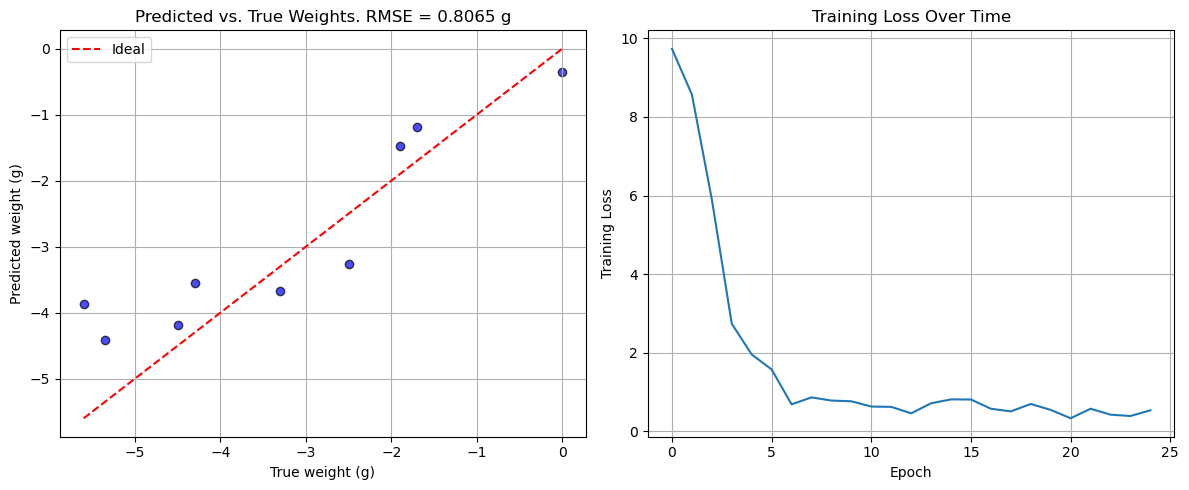


Final Model Summary:
- Hidden channels: 71
- Kernel size: 23
- Stride: 20
- Dropout: 0.127
- Learning rate: 0.003442
- Device used: cuda


In [131]:
model.eval()
with torch.no_grad():
    # Move data to device and get predictions
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
    y_pred = model(X_val_tensor).squeeze().cpu().numpy()  # Move back to CPU for plotting
    y_true = y_val.squeeze()

# Create subplot for better visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: Predictions vs True values
ax1.scatter(y_true, y_pred, c="blue", alpha=0.7, edgecolors="k")
ax1.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], "r--", label="Ideal")
ax1.set_xlabel("True weight (g)")
ax1.set_ylabel("Predicted weight (g)")
ax1.set_title("Predicted vs. True Weights. RMSE = {:.4f} g".format(rmse))
ax1.legend()
ax1.grid(True)

# Plot 2: Training loss over epochs (if available)
if 'train_losses' in locals():
    ax2.plot(train_losses)
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Training Loss")
    ax2.set_title("Training Loss Over Time")
    ax2.grid(True)
else:
    ax2.text(0.5, 0.5, "Training loss not available", 
             ha='center', va='center', transform=ax2.transAxes)
    ax2.set_title("Training Loss")


prediction_folder = f"{fig_folder}/Predictions"
if not os.path.exists(prediction_folder):
    os.makedirs(prediction_folder)

plt.tight_layout()
plt.savefig(f"{prediction_folder}/model_prediction_{freq_start_khz}_{freq_stop_khz}kHz.png")
plt.show()

# Print final model summary
print(f"\nFinal Model Summary:")
print(f"- Hidden channels: {best_params['hidden_channels']}")
print(f"- Kernel size: {best_params['kernel_size']}")
print(f"- Stride: {best_params['stride']}")
print(f"- Dropout: {best_params['dropout']:.3f}")
print(f"- Learning rate: {best_params['lr']:.6f}")
print(f"- Device used: {device}")

## 9. RMSD Analysis

In [132]:
# # Take real impedance from first dataset as reference
# R_ref = datasets[0]["R"]
# weight_ref = datasets[0]["weight_g"]
# freq_ref = datasets[0]["f"] / 1000  # Convert to kHz

# # Filter reference data by frequency range
# freq_mask_ref = (freq_ref >= freq_start_khz) & (freq_ref <= freq_stop_khz)
# R_ref_filtered = R_ref[freq_mask_ref]

# # Compute RMSD between R_ref and all other R datasets
# rmsd_values = []
# weights = []

# for d in datasets:
#     # Filter data by frequency range
#     freq_khz = d["f"] / 1000
#     freq_mask = (freq_khz >= freq_start_khz) & (freq_khz <= freq_stop_khz)
#     R_d = d["R"][freq_mask]
    
#     # Compute normalized RMSD
#     diff_norm = np.sqrt(((R_d - R_ref_filtered)**2) / (R_ref_filtered**2))
#     rmsd = np.nansum(diff_norm)  # equivalent to sum(..., 'omitnan')
    
#     rmsd_values.append(rmsd)
#     weights.append(weight_ref - d["weight_g"])

# # Plot RMSD vs weights
# plt.figure(figsize=(8, 6))
# plt.plot(weights, rmsd_values, 'o-', color='blue', alpha=0.7, markersize=6, linewidth=1.5)

# # Add linear trend line
# z = np.polyfit(weights, rmsd_values, 1)
# p = np.poly1d(z)
# plt.plot(weights, p(weights), "r--", alpha=0.8, linewidth=2, label=f'Linear trend (slope={z[0]:.3f})')

# plt.xlabel('Weight difference from reference (g)')
# plt.ylabel('RMSD')
# plt.title(f'RMSD vs Weight ({freq_start_khz}-{freq_stop_khz} kHz)')
# plt.grid(True, alpha=0.3)
# plt.legend()
# plt.tight_layout()

# # Save the plot
# plt.savefig(f'{fig_folder}/RMSD/rmsd_vs_weight_{freq_start_khz}_{freq_stop_khz}kHz.png', dpi=300, bbox_inches='tight')
# plt.show()

# print(f"RMSD analysis completed for frequency range {freq_start_khz}-{freq_stop_khz} kHz")
# print(f"Number of datasets analyzed: {len(rmsd_values)}")
# print(f"RMSD range: {np.min(rmsd_values):.3f} to {np.max(rmsd_values):.3f}")
# print(f"Linear trend slope: {z[0]:.6f}")
# print(f"Reference weight: {weight_ref:.2f}g")

# Work with acclereated corrosion data

## Load data

Found 8 unique samples: ['sample_1', 'sample_2', 'sample_3', 'sample_4', 'sample_5', 'sample_6', 'sample_7', 'sample_8']
Found 54 timestamped directories
Processing 2025-09-30_06-00-03 (1/54)
Processing 2025-09-30_08-18-27 (2/54)
Processing 2025-09-30_18-00-03 (3/54)
Processing 2025-10-01_06-00-03 (4/54)
Processing 2025-10-01_12-27-23 (5/54)
Processing 2025-10-01_18-00-03 (6/54)
Processing 2025-10-02_06-00-03 (7/54)
Processing 2025-10-02_18-00-03 (8/54)
Processing 2025-10-03_06-00-02 (9/54)
Processing 2025-10-03_18-00-02 (10/54)
Processing 2025-10-04_06-00-03 (11/54)
Processing 2025-10-04_18-00-03 (12/54)
Processing 2025-10-05_06-00-04 (13/54)
Processing 2025-10-05_18-00-02 (14/54)
Processing 2025-10-06_06-00-03 (15/54)
Processing 2025-10-06_14-56-48 (16/54)
Processing 2025-10-07_06-00-03 (17/54)
Processing 2025-10-09_06-00-03 (18/54)
Processing 2025-10-09_18-00-04 (19/54)
Processing 2025-10-10_06-00-03 (20/54)
Processing 2025-10-10_18-00-03 (21/54)
Processing 2025-10-11_06-00-04 (22/5

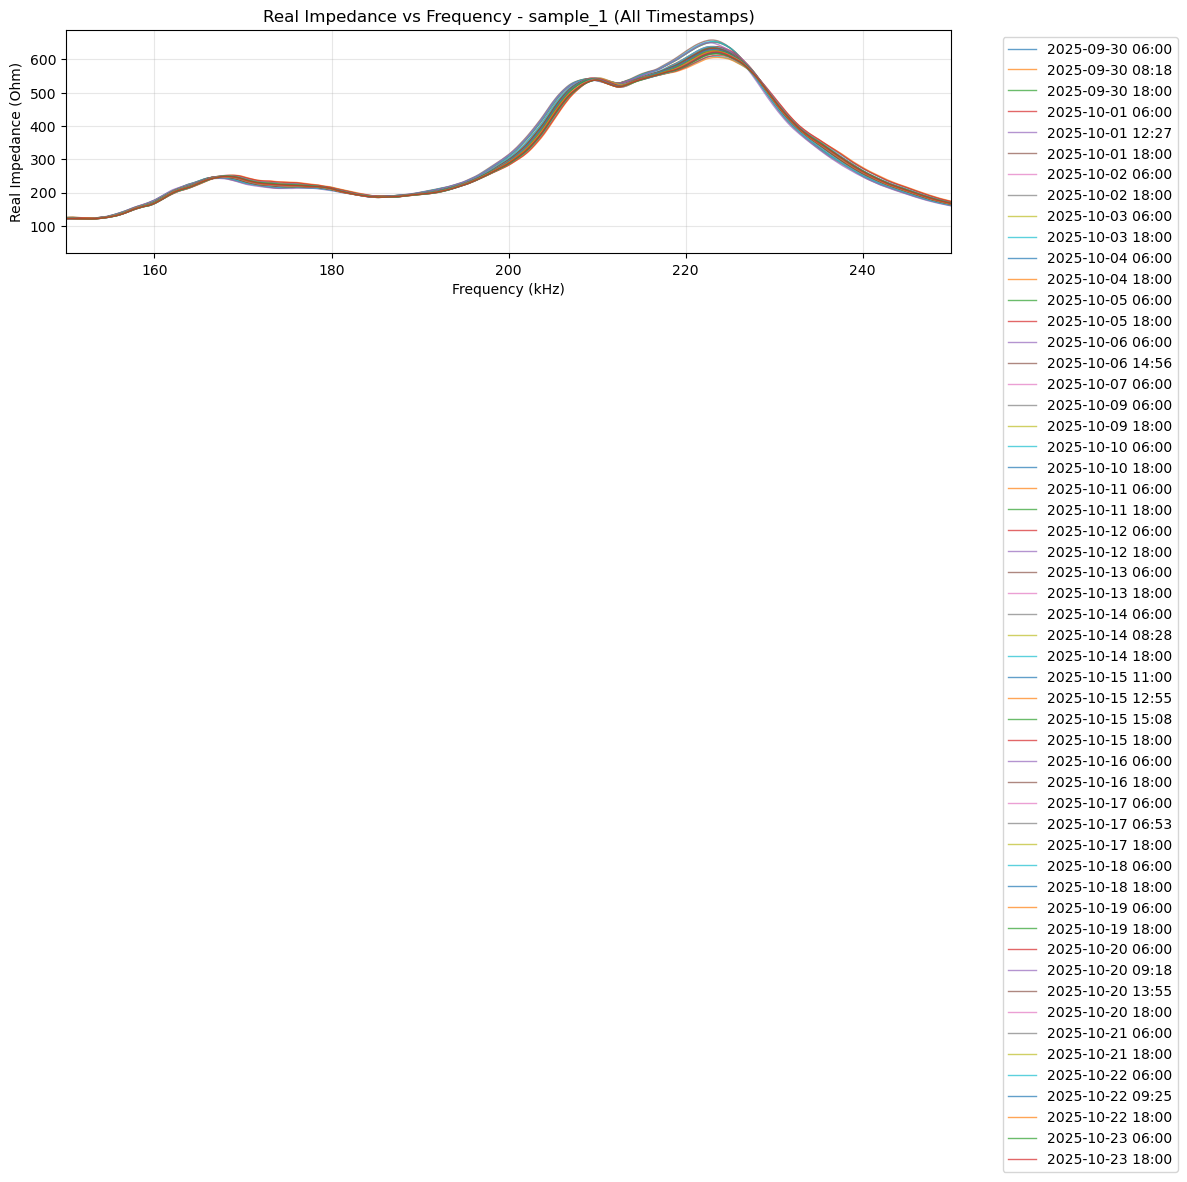

Plotted 54 measurements for sample_1


In [133]:
# Add parent directory to Python path so we can import from src
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

# Import the loading function
from src.Load_Accelerated_corrosion_test_data import load_accelerated_corrosion_data

# Load the data
data = load_accelerated_corrosion_data()

# Access the components
frequencies = data['frequency']          # Array of 9000 frequency points (50-500 kHz)
real_impedance = data['real_data']       # DataFrame: timestamps × samples
imag_impedance = data['imag_data']       # DataFrame: timestamps × samples  
timestamps = data['timestamps']          # DatetimeIndex of measurement times
sample_names = data['sample_names']      # List of available samples

# Plot all real impedance data from sample_6
plt.figure(figsize=(12, 8))

sample_to_plot = "sample_1"

if sample_to_plot in real_impedance.columns:
    # Get all non-null measurements for sample_6
    sample_data = real_impedance[sample_to_plot].dropna()
    
    # Plot each timestamp's data
    for timestamp, impedance_array in sample_data.items():
        plt.plot(frequencies / 1000, impedance_array, 
                alpha=0.7, linewidth=1, 
                label=f'{timestamp.strftime("%Y-%m-%d %H:%M")}')
    
    plt.xlim(150, 250)
    plt.xlabel("Frequency (kHz)")
    plt.ylabel("Real Impedance (Ohm)")
    plt.title(f"Real Impedance vs Frequency - {sample_to_plot} (All Timestamps)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"Plotted {len(sample_data)} measurements for {sample_to_plot}")
else:
    print(f"{sample_to_plot} not found in available samples: {sample_names}")

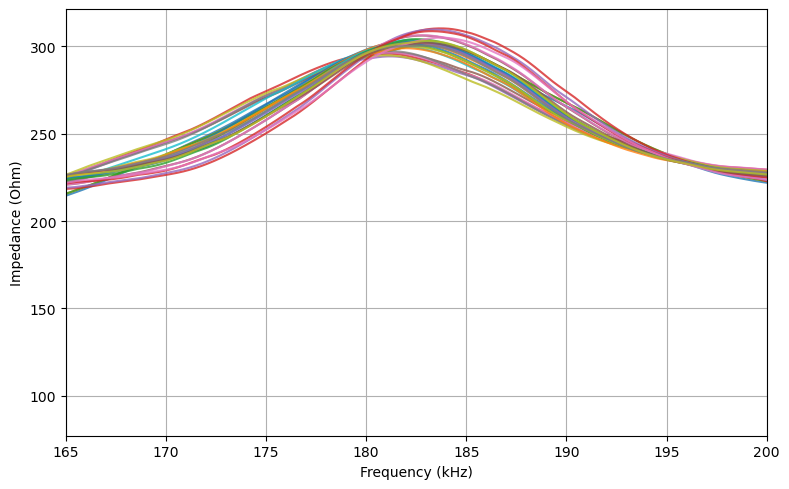

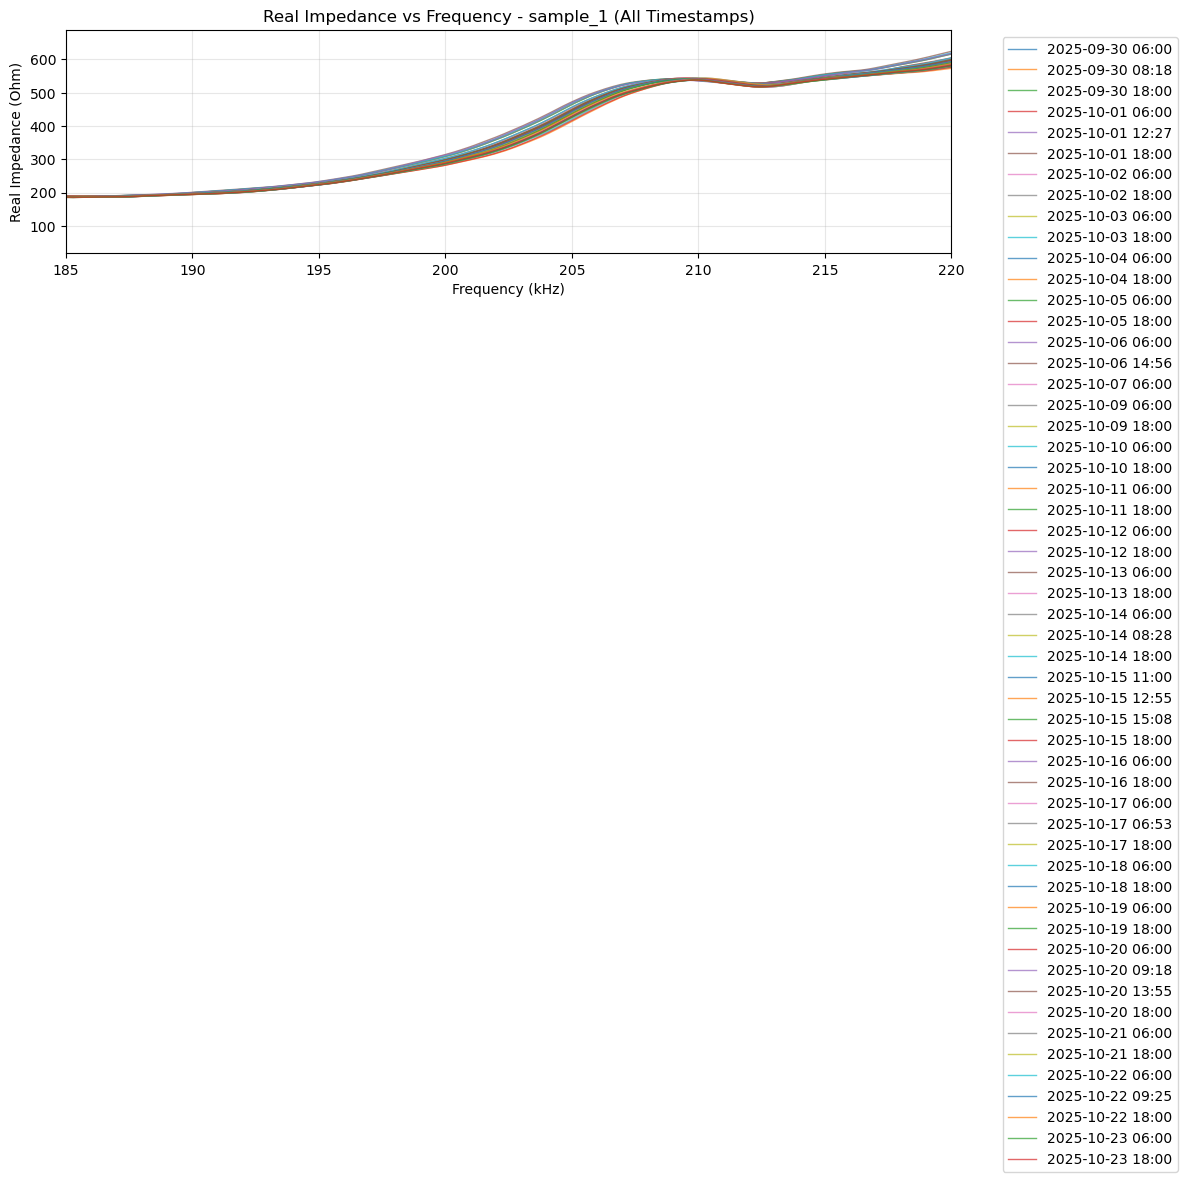

In [134]:
plt.figure(figsize=(8, 5))
for d in datasets:
    label = f"{d['temperature_C']}°C, {d['weight_g']:.2f}g"
    plt.plot(d["f"] / 1000, d["R"], label=f"R - {label}", alpha=0.8)
    #plt.plot(d["f"] / 1000, d["Xc"], linestyle="--", label=f"Xc - {label}", alpha=0.8)

plt.xlim(50, 500)
plt.xlim(165, 200)
plt.xlabel("Frequency (kHz)")
plt.ylabel("Impedance (Ohm)")
#plt.legend(fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()


# Plot all real impedance data from sample_6
plt.figure(figsize=(12, 8))

sample_to_plot = "sample_1"

if sample_to_plot in real_impedance.columns:
    # Get all non-null measurements for sample_6
    sample_data = real_impedance[sample_to_plot].dropna()
    
    # Plot each timestamp's data
    for timestamp, impedance_array in sample_data.items():
        plt.plot(frequencies / 1000, impedance_array, 
                alpha=0.7, linewidth=1, 
                label=f'{timestamp.strftime("%Y-%m-%d %H:%M")}')
    
    plt.xlim(50, 500)
    plt.xlabel("Frequency (kHz)")
    plt.ylabel("Real Impedance (Ohm)")
    plt.title(f"Real Impedance vs Frequency - {sample_to_plot} (All Timestamps)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.xlim(165+20, 200+20)

    plt.show()
    

In [135]:
# import numpy as np
# from scipy.ndimage import uniform_filter1d

# # Define window size (tune as needed)
# window_size = 100

# # Apply moving mean along each feature vector (axis=1)
# X_data_smooth = uniform_filter1d(X_data, size=window_size, axis=1, mode='nearest')

# index = 1

# plt.plot(X_eval_data[index, 0:], label="R feature")
# plt.plot(X_data_smooth[25, 0:], label="R feature")
# plt.title(f"{timestamps_eval[index]} - Smoothed R Feature")
# plt.ylim(0.8,1.2)

## Prepare data for pytorch

In [164]:
# Prepare accelerated corrosion test data for PyTorch evaluation

sample_to_evaluate = "sample_6"
freq_offset = 20  # kHz

print(f"Using frequency range: {freq_start_khz + freq_offset} - {freq_stop_khz + freq_offset} kHz")

if sample_to_evaluate in real_impedance.columns:
    sample_data = real_impedance[sample_to_evaluate].dropna()

    start_date = pd.Timestamp("2025-10-15")
    end_date = pd.Timestamp("2025-10-22 23:59:59")

    date_mask = (sample_data.index >= start_date) & (sample_data.index <= end_date)
    sample_data_filtered = sample_data[date_mask]

    print(f"Original data points: {len(sample_data)}")
    print(f"Filtered data points ({start_date} to {end_date}): {len(sample_data_filtered)}")

    if len(sample_data_filtered) == 0:
        print(f"No data found in the specified date range for {sample_to_evaluate}")
        X_eval_data = None
        X_eval_tensor = None
        timestamps_eval = None
    else:
        freq_khz = frequencies / 1000
        freq_mask = (freq_khz >= freq_start_khz + freq_offset) & (freq_khz <= freq_stop_khz + freq_offset)

        X_eval_data = []
        timestamps_eval = []

        print(f"Processing {len(sample_data_filtered)} measurements for {sample_to_evaluate}")

        for timestamp, R_array in sample_data_filtered.items():
            R_filtered = R_array[freq_mask]

            # Get imaginary component
            imag_data_sample = imag_impedance[sample_to_evaluate].dropna()
            imag_data_filtered = imag_data_sample[date_mask]
            Xc_filtered = imag_data_filtered.loc[timestamp][freq_mask]

            # First measurement defines normalization reference
            if len(X_eval_data) == 0:
                R_ref_eval = R_filtered
                Xc_ref_eval = Xc_filtered
                print(f"Using first measurement ({timestamp}) as reference for normalization")

            freqs_eval = frequencies[freq_mask]

            # --- Use the same feature extraction as in training ---
            features = extract_impedance_features(
                freqs_eval,
                R_filtered,
                Xc_filtered,
                R_ref_eval,
                Xc_ref_eval
            )

            

            X_eval_data.append(features)
            timestamps_eval.append(timestamp)

        # Convert to numpy array
        X_eval_data = np.array(X_eval_data, dtype=np.float32)

        # Apply same scaler as training
        #scaler = StandardScaler()
        #X_eval_data = scaler.fit_transform(X_data)
        #X_eval_data = scaler.transform(X_eval_data)

        # Convert to PyTorch tensor
        X_eval_tensor = torch.tensor(X_eval_data, dtype=torch.float32)

        print(f"PyTorch tensor shape: {X_eval_tensor.shape}")
        print("Ready for model evaluation!")



Using frequency range: 185 - 220 kHz
Original data points: 35
Filtered data points (2025-10-15 00:00:00 to 2025-10-22 23:59:59): 7
Processing 7 measurements for sample_6
Using first measurement (2025-10-15 11:00:19) as reference for normalization
PyTorch tensor shape: torch.Size([7, 1])
Ready for model evaluation!


/tmp/ipykernel_851/753938169.py:63: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area_diff = np.trapz(np.abs(R - R_ref), freqs)


Predictions completed!
Number of predictions: 7
Predictions range: -0.4228 to -0.3162
Mean prediction: -0.3791
Std prediction: 0.0344

Prediction results:
            timestamp  predicted_weight_change  predicted_absolute_weight
0 2025-10-15 11:00:19                -0.316183                 114.683815
1 2025-10-20 18:00:03                -0.383240                 114.616760
2 2025-10-21 06:00:04                -0.394426                 114.605576
3 2025-10-21 18:00:04                -0.400952                 114.599045
4 2025-10-22 06:00:04                -0.422803                 114.577194


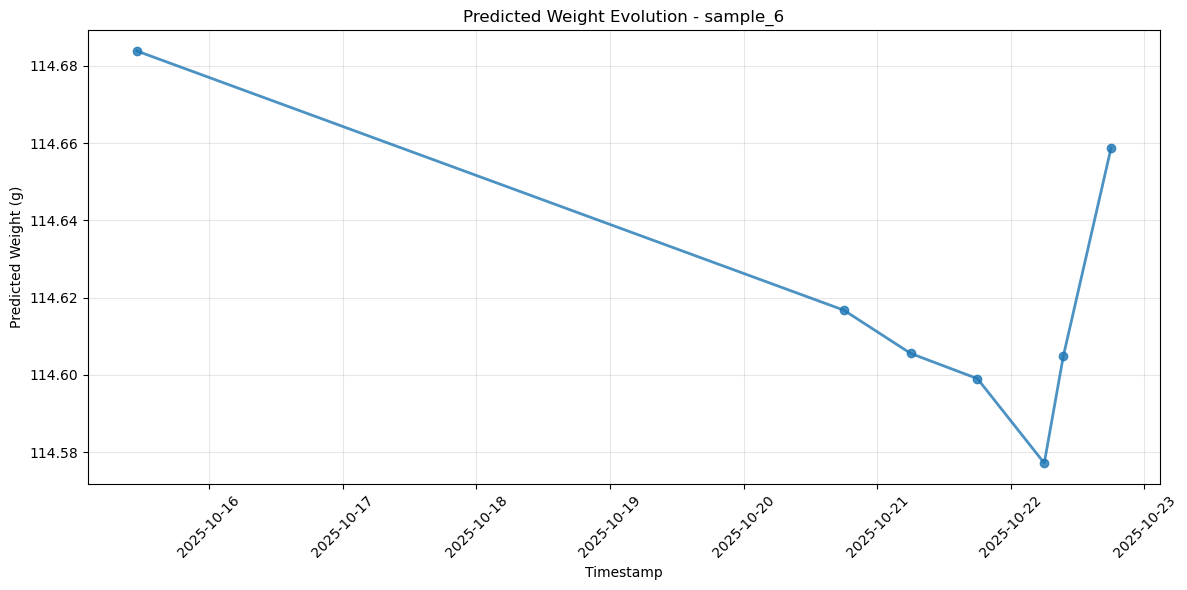

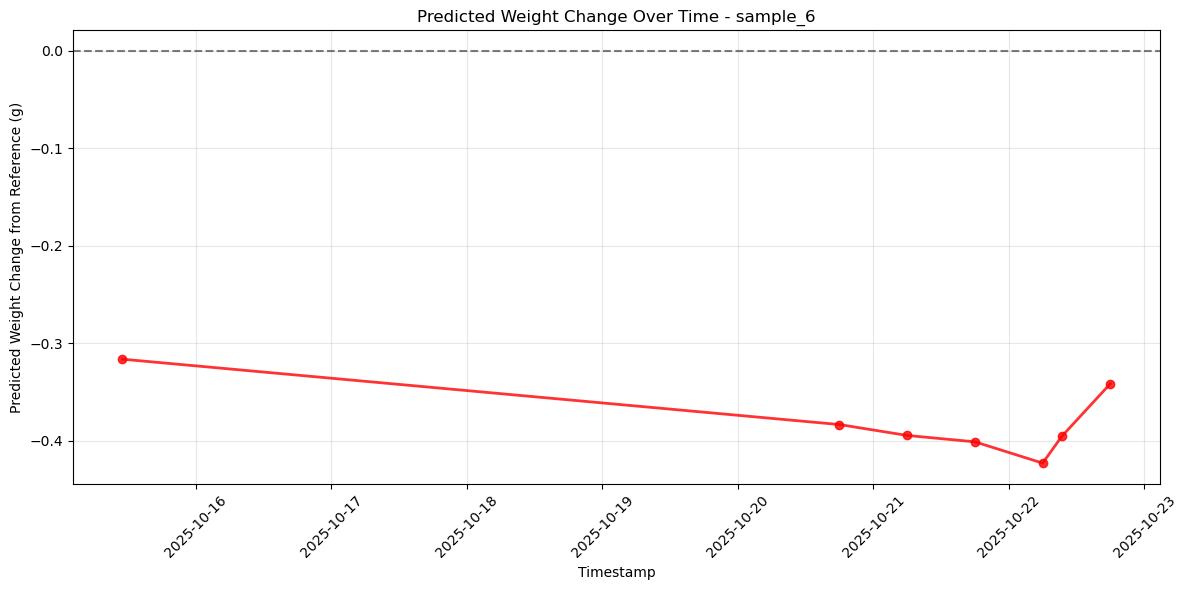

In [151]:
# Evaluate trained model on accelerated corrosion test data
if X_eval_tensor is not None and model is not None:
    # Set model to evaluation mode
    model.eval()
    
    # Move evaluation data to the same device as the model
    X_eval_tensor = X_eval_tensor.to(device)
    
    # Make predictions
    with torch.no_grad():
        predictions = model(X_eval_tensor)
        predictions = predictions.squeeze().cpu().numpy()  # Move back to CPU for analysis
    
    print(f"Predictions completed!")
    print(f"Number of predictions: {len(predictions)}")
    print(f"Predictions range: {predictions.min():.4f} to {predictions.max():.4f}")
    print(f"Mean prediction: {predictions.mean():.4f}")
    print(f"Std prediction: {predictions.std():.4f}")
    
    # Create a results DataFrame
    results_df = pd.DataFrame({
        'timestamp': timestamps_eval,
        'predicted_weight_change': predictions,
        'predicted_absolute_weight': predictions + 115.0  # Add back the reference weight
    })
    
    print(f"\nPrediction results:")
    print(results_df.head())
    
    # Plot predictions over time
    plt.figure(figsize=(12, 6))
    plt.plot(results_df['timestamp'], results_df['predicted_absolute_weight'], 
             'o-', linewidth=2, markersize=6, alpha=0.8)
    plt.xlabel('Timestamp')
    plt.ylabel('Predicted Weight (g)')
    plt.title(f'Predicted Weight Evolution - {sample_to_evaluate}')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Plot weight change predictions
    plt.figure(figsize=(12, 6))
    plt.plot(results_df['timestamp'], results_df['predicted_weight_change'], 
             'o-', color='red', linewidth=2, markersize=6, alpha=0.8)
    plt.xlabel('Timestamp')
    plt.ylabel('Predicted Weight Change from Reference (g)')
    plt.title(f'Predicted Weight Change Over Time - {sample_to_evaluate}')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    plt.tight_layout()
    #plt.ylim(-5, 0)
    plt.show()
    
else:
    if X_eval_tensor is None:
        print("No evaluation data available. Please run the data preparation cell first.")
    if model is None:
        print("No trained model available. Please run the training cells first.")